In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import joblib
joblib.dump(rf_model, '/content/drive/My Drive/rf_model.pkl')


['/content/drive/My Drive/rf_model.pkl']

In [ ]:
file_path = '/content/drive/My Drive/datasets/natality2023us.csv'


In [ ]:
# ------- Only Run First Time, Skip to next then after ------- #
import pandas as pd

# Load only necessary columns or in chunks for large data
df = pd.read_csv(file_path, low_memory=False)
df.shape  # Check size

# Save as Parquet for faster loading later
df.to_parquet('/content/drive/My Drive/datasets/natality2023us.parquet')


In [ ]:
import pandas as pd
# Reload quickly
df = pd.read_parquet('/content/drive/My Drive/datasets/natality2023us.parquet')

In [ ]:
# Step 2: Select only the needed columns
usecols = [
    'bfacil', 'mager', 'mager9', 'mbstate_rec', 'mracehisp', 'dmar',
    'meduc', 'lbo_rec', 'illb_r11', 'precare5', 'previs', 'wic',
    'cig_0', 'cig_1', 'cig_2', 'cig_3', 'm_ht_in', 'bmi_r', 'pwgt_r', 'dwgt_r', 'wtgain',
    'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype',
    'rf_inftr', 'rf_fedrg', 'rf_artec',
    'ob_ecvs', 'ld_indl', 'ld_augm', 'ld_anes',
    'me_pres', 'dmeth_rec', 'attend', 'pay_rec',
    'dplural', 'sex', 'combgest', 'dbwt'
]
df = df[usecols]

In [ ]:
# STEP 3: Filter and preprocess
import numpy as np

# Step 4: Apply inclusion criteria
filtered = df[
    (df['dplural'] == 1) &
    df['dmeth_rec'].notna() &
    df['mager'].notna() &
    df['mracehisp'].notna() &
    df['previs'].notna() & (df['previs'] != 99) &
    (df['bfacil'] == 1)
].copy()

# Step 5: Recoding categorical variables
filtered['bfacil'] = filtered['bfacil'].map({1: 'Hospital'})

filtered['mracehisp'] = filtered['mracehisp'].map({
    1: 'Non-Hispanic White', 2: 'Non-Hispanic Black', 3: 'Non-Hispanic AIAN',
    4: 'Non-Hispanic Asian', 5: 'Non-Hispanic NHOPI', 6: 'Non-Hispanic Multiple',
    7: 'Hispanic', 8: 'Unknown'
})

filtered['dmar'] = filtered['dmar'].map({1: 'Married', 2: 'Unmarried'})

filtered['meduc'] = filtered['meduc'].map({
    1: '<=8th Grade', 2: '9-12 No Diploma', 3: 'HS Grad/GED',
    4: 'Some College', 5: 'Associate', 6: "Bachelor's",
    7: "Master's", 8: 'Doctorate/Professional'
})

filtered['precare5'] = filtered['precare5'].map({
    1: '1st-3rd Month', 2: '4th-6th Month', 3: '7th to Final',
    4: 'No Prenatal Care', 5: 'Unknown'
})

filtered['pay_rec'] = filtered['pay_rec'].map({
    1: 'Medicaid', 2: 'Private Insurance', 3: 'Self Pay', 4: 'Other'
})

filtered['dmeth_rec'] = filtered['dmeth_rec'].map({
    1: 'Vaginal', 2: 'C-section'
})

filtered['sex'] = filtered['sex'].map({'M': 'Male', 'F': 'Female'})

# View the first few rows
filtered.head()


,bfacil,mager,mager9,mbstate_rec,mracehisp,dmar,meduc,lbo_rec,illb_r11,precare5,...,ld_augm,ld_anes,me_pres,dmeth_rec,attend,pay_rec,dplural,sex,combgest,dbwt
0,Hospital,37,6,1,Non-Hispanic AIAN,Unmarried,Master's,2,4,1st-3rd Month,...,N,N,1,Vaginal,1,Medicaid,1,Female,39,3625
1,Hospital,29,4,2,Non-Hispanic NHOPI,Married,Associate,2,8,1st-3rd Month,...,N,Y,1,Vaginal,1,Other,1,Male,39,3284
2,Hospital,22,3,1,Hispanic,Married,Some College,2,3,1st-3rd Month,...,N,Y,1,C-section,1,Other,1,Male,39,3097
3,Hospital,21,3,1,Non-Hispanic White,Married,Associate,3,4,1st-3rd Month,...,N,Y,1,Vaginal,3,Other,1,Female,37,3249
4,Hospital,35,6,2,Non-Hispanic Asian,Unmarried,9-12 No Diploma,1,88,1st-3rd Month,...,Y,Y,1,C-section,1,Other,1,Female,39,3765


In [ ]:
# Step 6: List of categorical variables
categorical_vars = [
    "bfacil", "mracehisp", "dmar", "meduc", "mager9", "mbstate_rec",
    "lbo_rec", "illb_r11", "precare5", "wic", "bmi_r",
    "rf_pdiab", "rf_gdiab", "rf_phype", "rf_ghype", "rf_ehype", "rf_inftr",
    "rf_fedrg", "rf_artec", "ob_ecvs", "ld_indl", "ld_augm",
    "ld_anes", "me_pres", "dmeth_rec", "attend", "pay_rec",
    "dplural", "sex"
]

# Step 7: Convert to pandas 'category' dtype
for col in categorical_vars:
    if col in filtered.columns:
        filtered[col] = filtered[col].astype("category")

# Step 8: Confirm data structure (similar to R's str())
filtered.info()

# Optional: View sample categories
for col in categorical_vars[:5]:  # just show a few
    if col in filtered.columns:
        print(f"\n{col} categories:\n", filtered[col].cat.categories)


<class 'pandas.core.frame.DataFrame'>
Index: 3347312 entries, 0 to 3605080
Data columns (total 41 columns):
 #   Column       Dtype   
---  ------       -----   
 0   bfacil       category
 1   mager        int64   
 2   mager9       category
 3   mbstate_rec  category
 4   mracehisp    category
 5   dmar         category
 6   meduc        category
 7   lbo_rec      category
 8   illb_r11     category
 9   precare5     category
 10  previs       int64   
 11  wic          category
 12  cig_0        int64   
 13  cig_1        int64   
 14  cig_2        int64   
 15  cig_3        int64   
 16  m_ht_in      int64   
 17  bmi_r        category
 18  pwgt_r       int64   
 19  dwgt_r       int64   
 20  wtgain       int64   
 21  rf_pdiab     category
 22  rf_gdiab     category
 23  rf_phype     category
 24  rf_ghype     category
 25  rf_ehype     category
 26  rf_inftr     category
 27  rf_fedrg     category
 28  rf_artec     category
 29  ob_ecvs      category
 30  ld_indl      category
 

In [ ]:
##### Train / Validation / Test Split ###

from sklearn.model_selection import train_test_split
import pandas as pd # Ensure pandas is imported if not already

# Step 9: Define predictors (X) and target (y)
# Use dmeth_rec as the outcome variable
X = filtered.drop(columns=["dmeth_rec"])
y = filtered["dmeth_rec"]

# One-hot encode all categorical predictors
X_encoded = pd.get_dummies(X, drop_first=True)

# Drop rows with NaN values from both X_encoded and y before splitting
# This ensures the 'stratify' parameter does not receive NaN values
combined = X_encoded.copy()
combined['target'] = y # Temporarily combine to drop NaNs in sync
combined.dropna(inplace=True)

X_encoded_cleaned = combined.drop(columns=['target'])
y_cleaned = combined['target']


# Step 10: Train-validation-test split (60-20-20)
# Use the cleaned dataframes
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded_cleaned, y_cleaned, test_size=0.4, random_state=1, stratify=y_cleaned
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

# Step 11: Confirm shapes
print("Train:", X_train.shape)
print("Validation:", X_valid.shape)
print("Test:", X_test.shape)

Train: (2007655, 104)
Validation: (669219, 104)
Test: (669219, 104)


In [ ]:
import hashlib
import random
import pandas as pd
from sklearn.model_selection import train_test_split

# 🔐 Step 1: Generate 5 deterministic seeds from student ID
def generate_seeds_from_id(student_id, n=5):
    md5 = hashlib.md5(student_id.encode('utf-8')).hexdigest()
    seed_number = int(md5, 16)
    random.seed(seed_number)
    return [random.randint(0, 2**31 - 1) for _ in range(n)]

# 🆔 Student ID
student_id = "311982"
split_seeds = generate_seeds_from_id(student_id)
print("🔢 5 deterministic seeds:", split_seeds)

# 🧹 Step 2: Prepare cleaned X and y
X = filtered.drop(columns=["dmeth_rec"])
y = filtered["dmeth_rec"]
X_encoded = pd.get_dummies(X, drop_first=True)

# Drop NaNs in sync
combined = X_encoded.copy()
combined['target'] = y
combined.dropna(inplace=True)

X_encoded_cleaned = combined.drop(columns=['target'])
y_cleaned = combined['target']

# 📦 Step 3: Create 5 train/valid/test splits using different seeds
split_sets = []

for i, seed in enumerate(split_seeds):
    print(f"\n🔁 Splitting data using seed {seed} (#{i+1})")

    # 60% train, 40% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_encoded_cleaned, y_cleaned, test_size=0.4, random_state=seed, stratify=y_cleaned
    )

    # 20% validation, 20% test from temp
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp
    )

    split_sets.append({
        'seed': seed,
        'X_train': X_train,
        'X_valid': X_valid,
        'X_test': X_test,
        'y_train': y_train,
        'y_valid': y_valid,
        'y_test': y_test
    })

    print("Shapes → Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)


🔢 5 deterministic seeds: [318229462, 2068703232, 59169051, 1141743330, 1435688210]

🔁 Splitting data using seed 318229462 (#1)
Shapes → Train: (2007655, 104) Valid: (669219, 104) Test: (669219, 104)

🔁 Splitting data using seed 2068703232 (#2)
Shapes → Train: (2007655, 104) Valid: (669219, 104) Test: (669219, 104)

🔁 Splitting data using seed 59169051 (#3)
Shapes → Train: (2007655, 104) Valid: (669219, 104) Test: (669219, 104)

🔁 Splitting data using seed 1141743330 (#4)
Shapes → Train: (2007655, 104) Valid: (669219, 104) Test: (669219, 104)

🔁 Splitting data using seed 1435688210 (#5)
Shapes → Train: (2007655, 104) Valid: (669219, 104) Test: (669219, 104)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Only numeric columns can be correlated
correlation_matrix = X_encoded.corr().abs()


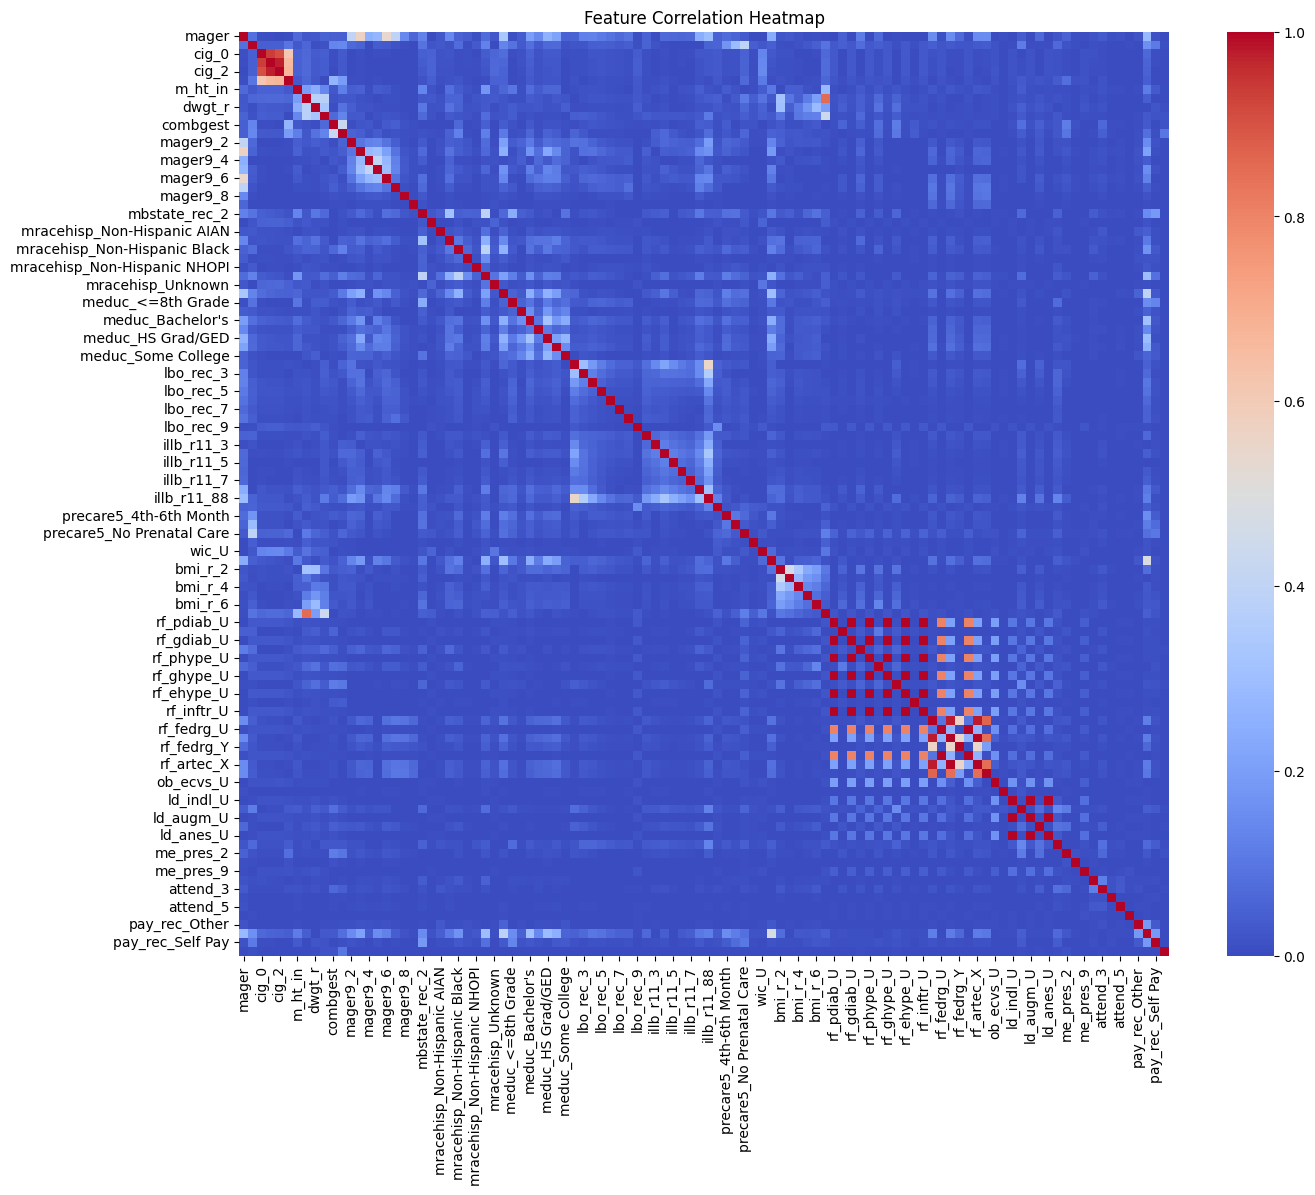

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmax=1.0, vmin=0.0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# Upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find columns with correlation > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"Columns to drop (correlation > 0.9): {len(to_drop)}\n", to_drop)


Columns to drop (correlation > 0.9): 12
 ['cig_1', 'cig_2', 'rf_gdiab_U', 'rf_phype_U', 'rf_ghype_U', 'rf_ehype_U', 'rf_inftr_U', 'rf_fedrg_X', 'rf_artec_U', 'rf_artec_X', 'ld_augm_U', 'ld_anes_U']


In [ ]:
X_encoded_reduced = X_encoded.drop(columns=to_drop)
print("Reduced X shape:", X_encoded_reduced.shape)


Reduced X shape: (3347312, 92)


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd # Ensure pandas is imported if not already

# Assume X_encoded, y, X_encoded_reduced exist from previous steps

# Recreate the cleaned dataframes to ensure alignment after feature reduction
# Combine the reduced features with the original target variable
combined_reduced = X_encoded_reduced.copy()
combined_reduced['target'] = y # Temporarily combine

# Drop rows with NaN values from the combined DataFrame
combined_reduced.dropna(inplace=True)

# Separate the cleaned data back into features and target
X_encoded_reduced_cleaned = combined_reduced.drop(columns=['target'])
y_cleaned = combined_reduced['target'] # This should be the same as the y_cleaned created before feature reduction

# Step 10: Train-validation-test split (60-20-20)
# Use the cleaned and reduced dataframes
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded_reduced_cleaned, y_cleaned, test_size=0.4, random_state=1, stratify=y_cleaned
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

# Step 11: Confirm shapes
print("Train:", X_train.shape, "| Validation:", X_valid.shape, "| Test:", X_test.shape)

Train: (2007655, 92) | Validation: (669219, 92) | Test: (669219, 92)


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd # Ensure pandas is imported if not already

# Assume X_encoded, y, X_encoded_reduced exist from previous steps

# Recreate the cleaned dataframes to ensure alignment after feature reduction
# Combine the reduced features with the original target variable
combined_reduced = X_encoded_reduced.copy()
combined_reduced['target'] = y # Temporarily combine

# Drop rows with NaN values from the combined DataFrame
combined_reduced.dropna(inplace=True)

# Separate the cleaned data back into features and target
X_encoded_reduced_cleaned = combined_reduced.drop(columns=['target'])
y_cleaned = combined_reduced['target'] # This should be the same as the y_cleaned created before feature reduction

In [ ]:
# Step 1: Make sure X_encoded_reduced_cleaned has the same index as original X_encoded
# (This should already be true if you didn't reset_index anywhere)

# Step 2: Apply the reduced features to each split using index alignment
X_train_reduced = X_encoded_reduced_cleaned.loc[X_train.index]
X_valid_reduced = X_encoded_reduced_cleaned.loc[X_valid.index]
X_test_reduced  = X_encoded_reduced_cleaned.loc[X_test.index]

print("Reduced Train shape:", X_train_reduced.shape)
print("Reduced Valid shape:", X_valid_reduced.shape)
print("Reduced Test shape:", X_test_reduced.shape)


Reduced Train shape: (2007655, 92)
Reduced Valid shape: (669219, 92)
Reduced Test shape: (669219, 92)


In [ ]:
### 1. Random Forest Model ####

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=100,         # number of trees
    max_depth=None,           # allow full depth
    random_state=1,
    n_jobs=-1,                # use all cores
    verbose=1
)

rf_model.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


RandomForestClassifier(n_jobs=-1, random_state=1, verbose=1)

In [ ]:
# Save model
import joblib
joblib.dump(rf_model, '/content/drive/My Drive/datasets/rf_model.pkl')

['/content/drive/My Drive/datasets/rf_model.pkl']

In [ ]:
# To reload:
joblib.dump(rf_model, '/content/drive/My Drive/datasets/rf_model.pkl')

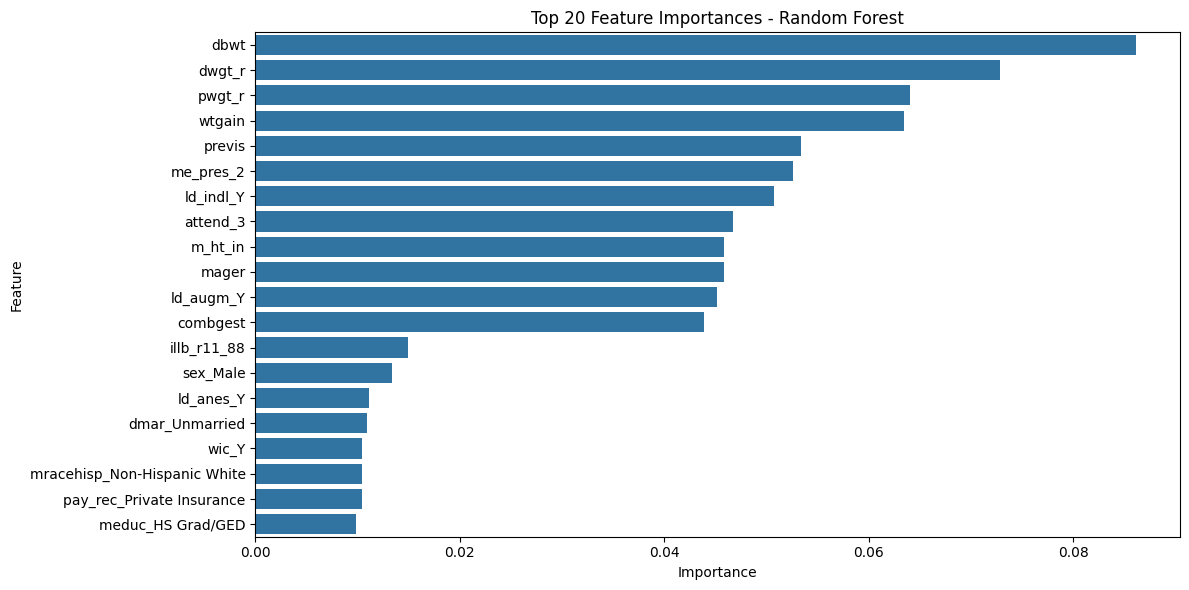

In [ ]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 20 features
top_n = 20
top_features = X_train.columns[indices[:top_n]]
top_importances = importances[indices[:top_n]]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


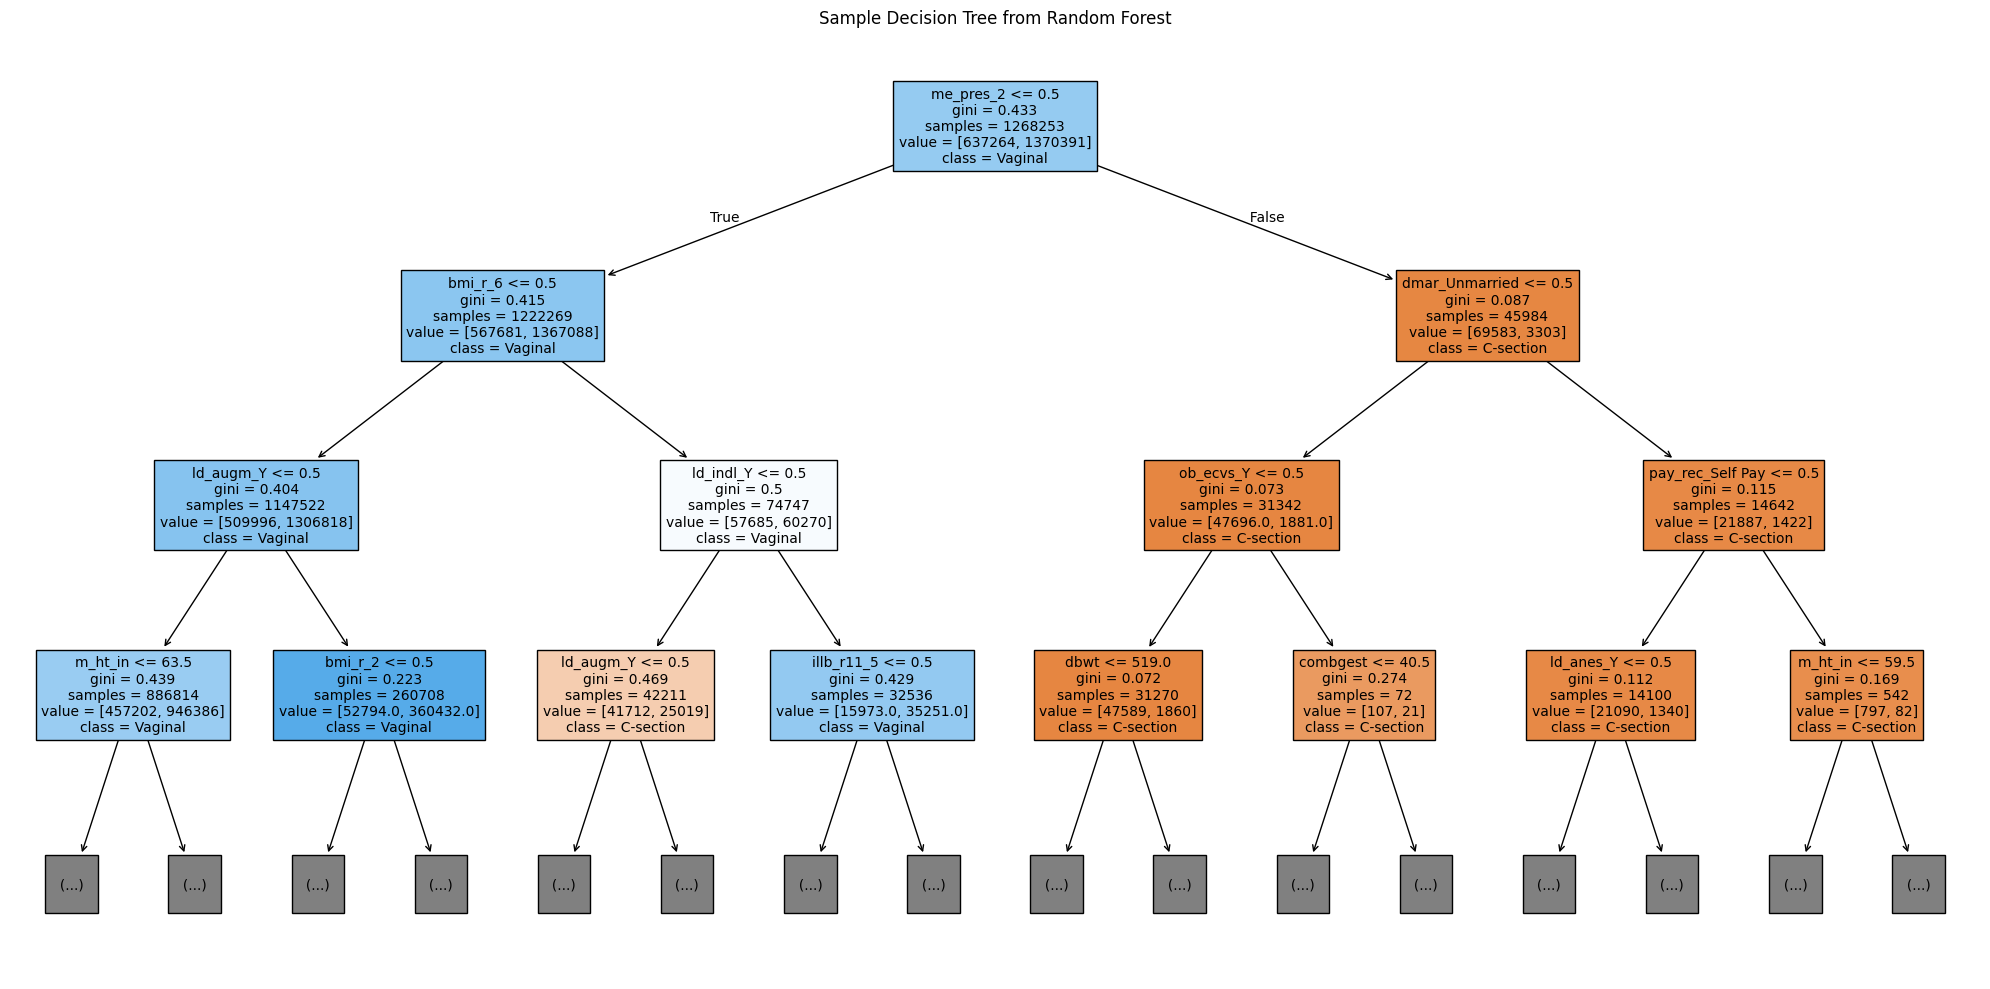

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the first tree in the forest
plt.figure(figsize=(20, 10))  # Customize size as needed

# Choose a single tree (e.g., the first one)
tree_to_plot = rf_model.estimators_[0]

# Plot with limited depth for readability
plot_tree(tree_to_plot,
          feature_names=X_train.columns,
          class_names=rf_model.classes_,
          filled=True,
          max_depth=3,   # limit depth to make it readable
          fontsize=10)

plt.title("Sample Decision Tree from Random Forest")
plt.tight_layout()
plt.show()


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    6.2s finished



🔍 Random Forest - C-section Risk Prediction
Accuracy: 0.7848492048193492
Confusion Matrix:
 [[408600  48443]
 [ 95540 116636]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85    457043
           1       0.71      0.55      0.62    212176

    accuracy                           0.78    669219
   macro avg       0.76      0.72      0.73    669219
weighted avg       0.78      0.78      0.78    669219

AUC: 0.8423149091323416


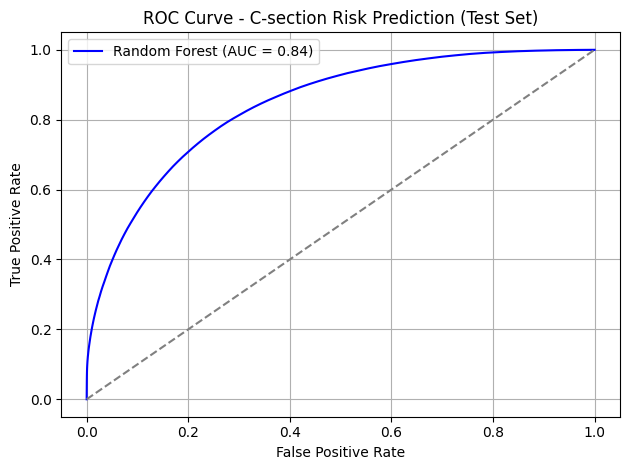

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Binary target: 1 = C-section
y_test_bin = (y_test == 'C-section').astype(int)

# Get probability of C-section
rf_csection_index = list(rf_model.classes_).index('C-section')
y_test_prob_rf = rf_model.predict_proba(X_test)[:, rf_csection_index]
y_test_pred_rf = rf_model.predict(X_test)

# Evaluation
print("\n🔍 Random Forest - C-section Risk Prediction")
print("Accuracy:", accuracy_score(y_test_bin, y_test_pred_rf == 'C-section'))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred_rf == 'C-section'))
print("Classification Report:\n", classification_report(y_test_bin, y_test_pred_rf == 'C-section'))
print("AUC:", roc_auc_score(y_test_bin, y_test_prob_rf))

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_bin, y_test_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test_bin, y_test_prob_rf):.2f})", color='blue')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - C-section Risk Prediction (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
### 2. XGBoost Model ####
!pip install xgboost

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt

# To store results
accuracies, f1_scores, aucs = [], [], []

# Optional: for ROC plot
all_fpr, all_tpr = [], []

# 🧹 Step 0: Clean column names in all splits before training
for split in split_sets:
    clean_columns = split['X_train'].columns.astype(str).str.replace(r'[\[\]<>]', '_', regex=True)
    split['X_train'].columns = clean_columns
    split['X_valid'].columns = clean_columns
    split['X_test'].columns = clean_columns

for i, split in enumerate(split_sets):
    print(f"\n🚀 Training XGBoost on Seed #{i+1} ({split['seed']})")

    # Binary labels
    y_train_bin = (split['y_train'] == 'C-section').astype(int)
    y_valid_bin = (split['y_valid'] == 'C-section').astype(int)
    y_test_bin  = (split['y_test']  == 'C-section').astype(int)

    # Create DMatrix
    dtrain = xgb.DMatrix(split['X_train'], label=y_train_bin)
    dvalid = xgb.DMatrix(split['X_valid'], label=y_valid_bin)
    dtest  = xgb.DMatrix(split['X_test'],  label=y_test_bin)

    # Define params (can use tuned ones)
    params = {
        'max_depth': 6,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': split['seed'],
        'verbosity': 0
    }

    # Train
    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dvalid, 'valid')], early_stopping_rounds=10, verbose_eval=False)

    # Predict on test
    y_pred_prob = model.predict(dtest)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)
    auc = roc_auc_score(y_test_bin, y_pred_prob)

    # Store metrics
    accuracies.append(acc)
    f1_scores.append(f1)
    aucs.append(auc)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred_prob)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

    print(f"✅ Accuracy: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

# Average metrics
avg_acc = sum(accuracies) / len(accuracies)
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_auc = sum(aucs) / len(aucs)

print("\n📊 Average Performance across 5 splits:")
print(f"🔹 Accuracy: {avg_acc:.4f}")
print(f"🔹 F1 Score: {avg_f1:.4f}")
print(f"🔹 ROC-AUC: {avg_auc:.4f}")



🚀 Training XGBoost on Seed #1 (318229462)
✅ Accuracy: 0.7882 | F1: 0.6179 | AUC: 0.8492

🚀 Training XGBoost on Seed #2 (2068703232)
✅ Accuracy: 0.7883 | F1: 0.6176 | AUC: 0.8489

🚀 Training XGBoost on Seed #3 (59169051)
✅ Accuracy: 0.7884 | F1: 0.6183 | AUC: 0.8487

🚀 Training XGBoost on Seed #4 (1141743330)
✅ Accuracy: 0.7886 | F1: 0.6187 | AUC: 0.8488

🚀 Training XGBoost on Seed #5 (1435688210)
✅ Accuracy: 0.7873 | F1: 0.6153 | AUC: 0.8481

📊 Average Performance across 5 splits:
🔹 Accuracy: 0.7882
🔹 F1 Score: 0.6176
🔹 ROC-AUC: 0.8487


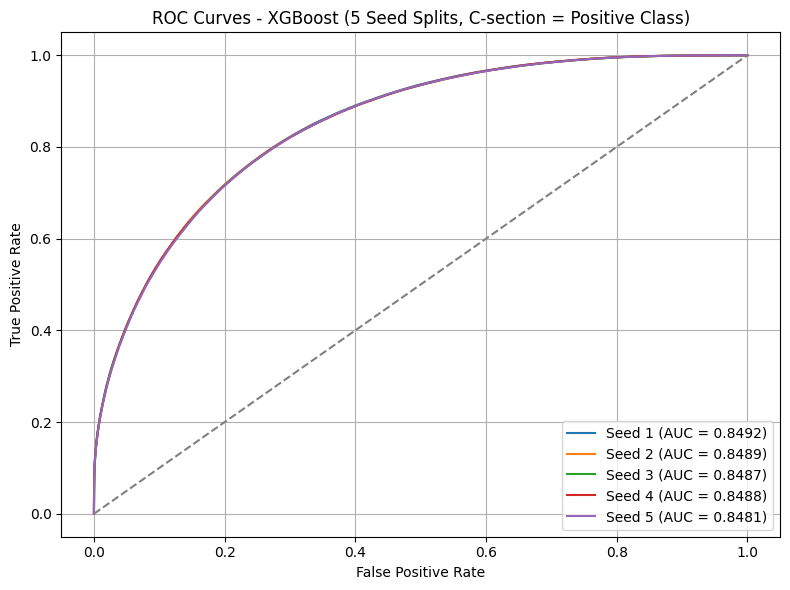

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(all_fpr[i], all_tpr[i], label=f"Seed {i+1} (AUC = {aucs[i]:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - XGBoost (5 Seed Splits, C-section = Positive Class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install optuna
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score
import pandas as pd

# Store all F1 scores per seed
all_f1_by_seed = []

for i, split in enumerate(split_sets):
    print(f"\n📊 Running Optuna for Seed #{i+1} ({split['seed']})")

    # Clean labels
    y_train_bin = (split['y_train'] == 'C-section').astype(int)
    y_valid_bin = (split['y_valid'] == 'C-section').astype(int)

    # Create DMatrix
    dtrain = xgb.DMatrix(split['X_train'], label=y_train_bin)
    dvalid = xgb.DMatrix(split['X_valid'], label=y_valid_bin)

    # Store F1 scores for this seed
    f1_scores_this_seed = []

    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'eta': trial.suggest_float('eta', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'seed': split['seed'],
            'verbosity': 0
        }

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=100,
            evals=[(dvalid, 'valid')],
            early_stopping_rounds=10,
            verbose_eval=False
        )

        preds = model.predict(dvalid)
        f1 = f1_score(y_valid_bin, preds > 0.5)
        f1_scores_this_seed.append(f1)
        return f1

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=split['seed']))
    study.optimize(objective, n_trials=30, show_progress_bar=False)

    all_f1_by_seed.append({
        'seed': split['seed'],
        'f1_scores': f1_scores_this_seed
    })


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.7 MB/s eta 0:00:00

📊 Running Optuna for Seed #1 (318229462)


[I 2025-07-17 14:39:07,800] A new study created in memory with name: no-name-4709749b-cc6e-48fc-8e67-74e220bca008
[I 2025-07-17 14:39:21,321] Trial 0 finished with value: 0.5534238637136378 and parameters: {'max_depth': 4, 'eta': 0.04737340592094348, 'subsample': 0.7393427289623173, 'colsample_bytree': 0.8394797585430962}. Best is trial 0 with value: 0.5534238637136378.
[I 2025-07-17 14:39:35,342] Trial 1 finished with value: 0.5317615440996823 and parameters: {'max_depth': 6, 'eta': 0.022087634499987387, 'subsample': 0.8857231119136193, 'colsample_bytree': 0.7183766766820697}. Best is trial 0 with value: 0.5534238637136378.
[I 2025-07-17 14:39:50,004] Trial 2 finished with value: 0.6009471130733653 and parameters: {'max_depth': 7, 'eta': 0.04533244916540782, 'subsample': 0.633646289509723, 'colsample_bytree': 0.9532969941346936}. Best is trial 2 with value: 0.6009471130733653.
[I 2025-07-17 14:40:04,772] Trial 3 finished with value: 0.6335936127074389 and parameters: {'max_depth': 8, 


📊 Running Optuna for Seed #2 (2068703232)


[I 2025-07-17 14:46:32,996] A new study created in memory with name: no-name-d8cf166e-26e7-4786-be32-8effc1c55253
[I 2025-07-17 14:46:46,950] Trial 0 finished with value: 0.6327006922827966 and parameters: {'max_depth': 6, 'eta': 0.2976275916922921, 'subsample': 0.9092991634176422, 'colsample_bytree': 0.7623405906610254}. Best is trial 0 with value: 0.6327006922827966.
[I 2025-07-17 14:46:59,878] Trial 1 finished with value: 0.6299059237598741 and parameters: {'max_depth': 6, 'eta': 0.21524832888431067, 'subsample': 0.7936458005471481, 'colsample_bytree': 0.6896551731399362}. Best is trial 0 with value: 0.6327006922827966.
[I 2025-07-17 14:47:12,269] Trial 2 finished with value: 0.6343328131709309 and parameters: {'max_depth': 9, 'eta': 0.29012258336263413, 'subsample': 0.8538906515928325, 'colsample_bytree': 0.6882877611792027}. Best is trial 2 with value: 0.6343328131709309.
[I 2025-07-17 14:47:23,333] Trial 3 finished with value: 0.6338014173269527 and parameters: {'max_depth': 10, 


📊 Running Optuna for Seed #3 (59169051)


[I 2025-07-17 14:53:24,642] A new study created in memory with name: no-name-019732ff-12d4-4f93-957a-046c9bee52b9
[I 2025-07-17 14:53:38,286] Trial 0 finished with value: 0.6196489927278687 and parameters: {'max_depth': 5, 'eta': 0.16278646106770384, 'subsample': 0.9822799395760109, 'colsample_bytree': 0.8513956944360477}. Best is trial 0 with value: 0.6196489927278687.
[I 2025-07-17 14:53:55,365] Trial 1 finished with value: 0.6309152088619769 and parameters: {'max_depth': 10, 'eta': 0.0867593009970213, 'subsample': 0.7511676719719191, 'colsample_bytree': 0.9785075042286836}. Best is trial 1 with value: 0.6309152088619769.
[I 2025-07-17 14:54:08,492] Trial 2 finished with value: 0.6338954495272677 and parameters: {'max_depth': 10, 'eta': 0.24851069032216422, 'subsample': 0.9274962434647227, 'colsample_bytree': 0.7666607599574359}. Best is trial 2 with value: 0.6338954495272677.
[I 2025-07-17 14:54:21,375] Trial 3 finished with value: 0.6296558426467792 and parameters: {'max_depth': 6,


📊 Running Optuna for Seed #4 (1141743330)


[I 2025-07-17 15:00:33,657] A new study created in memory with name: no-name-e4ffefff-7e5d-4099-ac00-0350caaa95fe
[I 2025-07-17 15:00:47,338] Trial 0 finished with value: 0.6084060338962675 and parameters: {'max_depth': 5, 'eta': 0.09454733941725998, 'subsample': 0.7543443147140241, 'colsample_bytree': 0.8525761813301722}. Best is trial 0 with value: 0.6084060338962675.
[I 2025-07-17 15:01:05,767] Trial 1 finished with value: 0.603043276536988 and parameters: {'max_depth': 10, 'eta': 0.030162331604525375, 'subsample': 0.6686035146913738, 'colsample_bytree': 0.7483235835386823}. Best is trial 0 with value: 0.6084060338962675.
[I 2025-07-17 15:01:16,463] Trial 2 finished with value: 0.6087084260523724 and parameters: {'max_depth': 3, 'eta': 0.25121913266632706, 'subsample': 0.6614706064060312, 'colsample_bytree': 0.8897002942560592}. Best is trial 2 with value: 0.6087084260523724.
[I 2025-07-17 15:01:27,060] Trial 3 finished with value: 0.6097142313080617 and parameters: {'max_depth': 3,


📊 Running Optuna for Seed #5 (1435688210)


[I 2025-07-17 15:07:37,171] A new study created in memory with name: no-name-124ccff0-404d-4ee2-99e8-3c5529f0eeff
[I 2025-07-17 15:07:52,263] Trial 0 finished with value: 0.6296468019828475 and parameters: {'max_depth': 7, 'eta': 0.14069428167393475, 'subsample': 0.9377518962902502, 'colsample_bytree': 0.7047627857725385}. Best is trial 0 with value: 0.6296468019828475.
[I 2025-07-17 15:08:01,661] Trial 1 finished with value: 0.6246973365617433 and parameters: {'max_depth': 4, 'eta': 0.2661244619596305, 'subsample': 0.8907587128789252, 'colsample_bytree': 0.9755551599099728}. Best is trial 0 with value: 0.6296468019828475.
[I 2025-07-17 15:08:15,370] Trial 2 finished with value: 0.6330714131584626 and parameters: {'max_depth': 7, 'eta': 0.19760470023493548, 'subsample': 0.8875940984003974, 'colsample_bytree': 0.8780588280887439}. Best is trial 2 with value: 0.6330714131584626.
[I 2025-07-17 15:08:28,821] Trial 3 finished with value: 0.6345183375234468 and parameters: {'max_depth': 8, '

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert seed to string for prettier x-axis labels
df_plot['Seed'] = df_plot['Seed'].astype(str)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Draw enhanced boxplot
ax = sns.boxplot(
    data=df_plot,
    x='Seed',
    y='Validation F1',
    palette='pastel',
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"},
    flierprops={"marker":"x", "markerfacecolor":"red", "markersize":5, "alpha":0.6}
)

# Title and labels
plt.title("📦 Optuna Validation F1 Score Distribution per Seed (C-section = Positive Class)", fontsize=14)
plt.xlabel("Random Seed", fontsize=12)
plt.ylabel("Validation F1 Score", fontsize=12)

# Grid and aesthetics
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


NameError: name 'df_plot' is not defined

In [ ]:
# Step 1: Find best F1 and the corresponding seed
best_f1 = -1
best_seed_index = -1
best_trial_index = -1

for i, entry in enumerate(all_f1_by_seed):
    max_f1 = max(entry['f1_scores'])
    if max_f1 > best_f1:
        best_f1 = max_f1
        best_seed_index = i
        best_trial_index = entry['f1_scores'].index(max_f1)

print(f"\n🏆 Best F1: {best_f1:.4f}")
print(f"Seed index: {best_seed_index}, Trial index: {best_trial_index}")



🏆 Best F1: 0.6364
Seed index: 4, Trial index: 15


In [ ]:
# Get the best split
split = split_sets[best_seed_index]

# Recombine full training data
X_full = pd.concat([split['X_train'], split['X_valid']])
y_full = pd.concat([split['y_train'], split['y_valid']])
y_full_bin = (y_full == 'C-section').astype(int)

# Binary test labels
y_test_bin = (split['y_test'] == 'C-section').astype(int)

# DMatrix for training and test
dfull = xgb.DMatrix(X_full, label=y_full_bin)
dtest = xgb.DMatrix(split['X_test'], label=y_test_bin)

# You can reuse the best hyperparameters from your Optuna setup
# For simplicity, we'll use same params used during tuning
best_seed = split['seed']
params = {
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': best_seed,
    'verbosity': 0
}

# Retrain best model on full data
final_model = xgb.train(params, dfull, num_boost_round=100)

# Predict on test set
y_test_prob = final_model.predict(dtest)
y_test_pred = (y_test_prob > 0.5).astype(int)



📈 Final Evaluation on Test Set
Accuracy: 0.7877
F1 Score: 0.6163
ROC-AUC: 0.8486
Confusion Matrix:
 [[412985  44058]
 [ 98038 114138]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85    457043
           1       0.72      0.54      0.62    212176

    accuracy                           0.79    669219
   macro avg       0.76      0.72      0.73    669219
weighted avg       0.78      0.79      0.78    669219



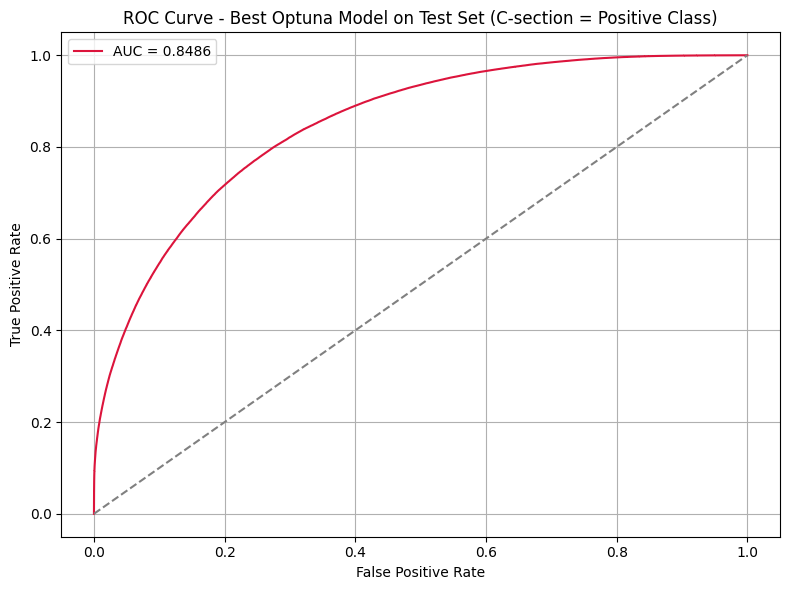

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Metrics
acc = accuracy_score(y_test_bin, y_test_pred)
f1 = f1_score(y_test_bin, y_test_pred)
auc = roc_auc_score(y_test_bin, y_test_prob)

print("\n📈 Final Evaluation on Test Set")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred))
print("Classification Report:\n", classification_report(y_test_bin, y_test_pred))

# Plot ROC
fpr, tpr, _ = roc_curve(y_test_bin, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='crimson')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Optuna Model on Test Set (C-section = Positive Class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install shap

import shap
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

shap.initjs()

In [ ]:
feature_name_map = {
    "attend_3": "Attendant at Birth",
    "ld_indl_Y": "Induction of Labor",
    "ld_augm_Y": "Augmentation of Labor",
    "me_pres_2": "Fetal Presentation at Delivery",
    "mager": "Mother’s Age",
    "m_ht_in": "Mother’s Height (in)",
    "illb_r11_88": "Interval Since Last Live Birth Recode",
    "dwgt_r": "Delivery Weight Recode",
    "ld_anes_Y": "Anesthesia",
    "dbwt": "Birth Weight (grams)",
    "combgest": "Combined Gestational Age (weeks)",
    "bmi_r_2": "Body Mass Index Recode",
    "rf_ghype_Y": "Gestational Hypertension",
    "mracehisp_Non-Hispanic Black": "Mother’s Race: Non-Hispanic Black",
    "lbo_rec_2": "Live Birth Order Recode: 2nd",
    "sex_Male": "Infant Sex: Male",
    "wtgain": "Weight Gain",
    "dmar_Unmarried": "Marital Status: Unmarried",
    "rf_phype_Y": "Pre-pregnancy Hypertension",
    "rf_gdiab_Y": "Gestational Diabetes"
}


In [ ]:
# final_model is your trained xgb.Booster object
# Use the full test feature set
X_test_df = split['X_test']  # Make sure this is a pandas DataFrame
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_df)


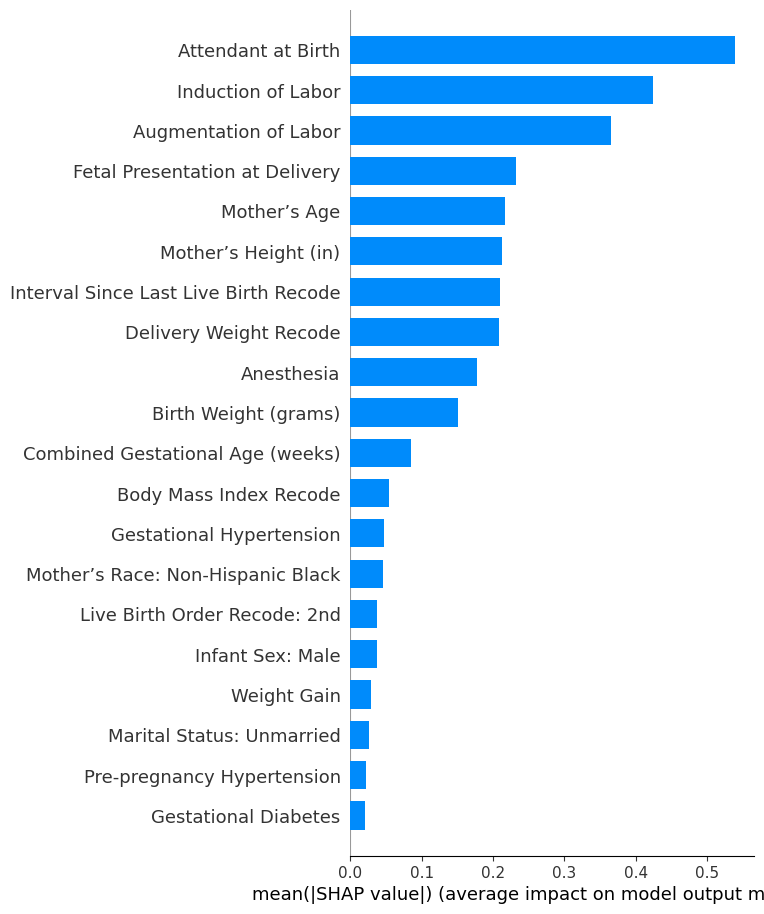

In [ ]:
import matplotlib.pyplot as plt
import shap

# Increase figure size
plt.figure(figsize=(30, 10))  # wider and taller

# Draw SHAP bar summary plot with improved layout
shap.summary_plot(
    shap_values,
    X_test_renamed,
    plot_type="bar",
    max_display=20,
    show=False  # prevent auto display so we can adjust layout
)

plt.tight_layout(pad=2.0)  # more spacing to avoid clipping
plt.show()


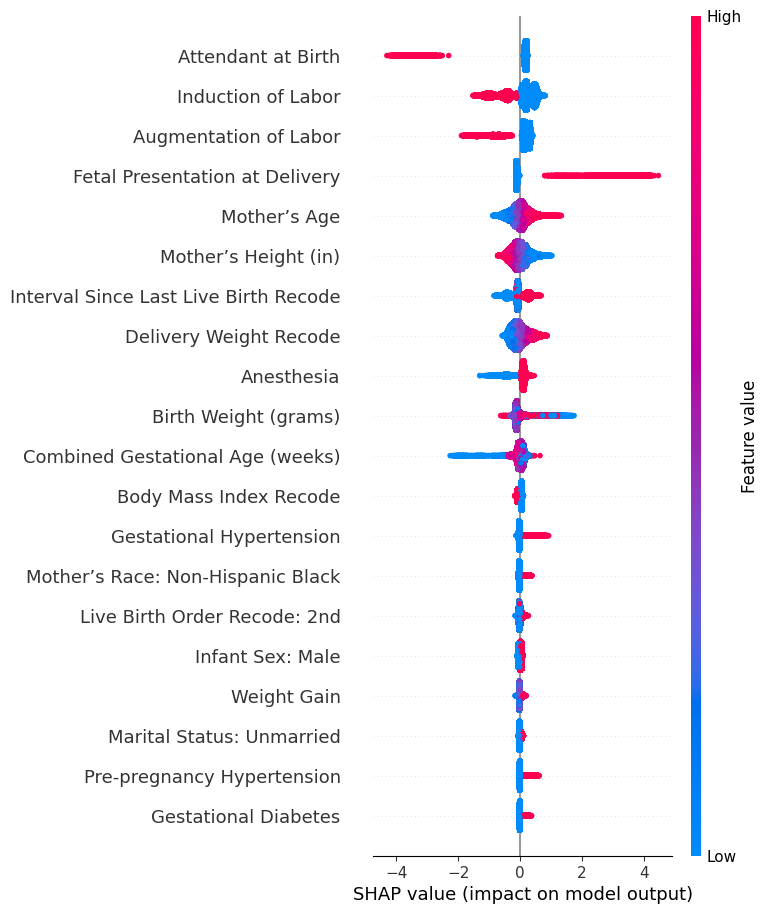

In [ ]:
import shap
import matplotlib.pyplot as plt

# Ensure consistent figure size
plt.figure(figsize=(12, 8))

# Full SHAP summary plot (distribution)
shap.summary_plot(
    shap_values,
    X_test_renamed,
    plot_type="dot",  # default: dot distribution plot
    max_display=20,
    show=False
)

plt.tight_layout(pad=2)
plt.show()


In [ ]:
# Choose any row from X_test
row_index = 161  # change as needed

# Create force plot object
force_plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[row_index],
    features=X_test_renamed.iloc[row_index],
    feature_names=X_test_renamed.columns
)

# Save as HTML file
shap.save_html("shap_force_plot_row161.html", force_plot)
from google.colab import files
files.download("shap_force_plot_row161.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📈 SHAP Dependence Plot for: Mother’s Age


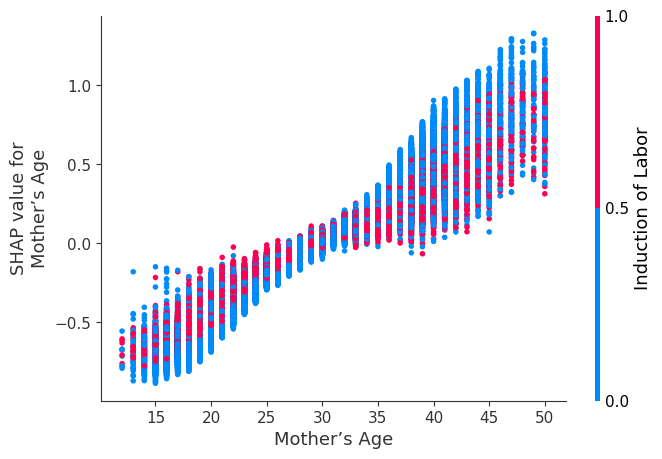


📈 SHAP Dependence Plot for: Mother’s Height (in)


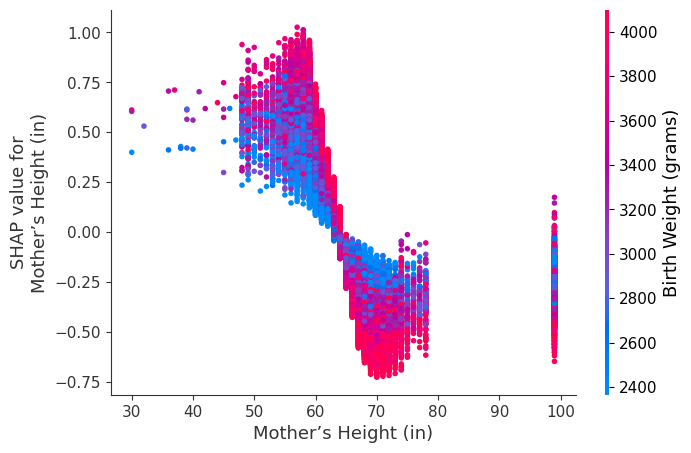


📈 SHAP Dependence Plot for: Delivery Weight Recode


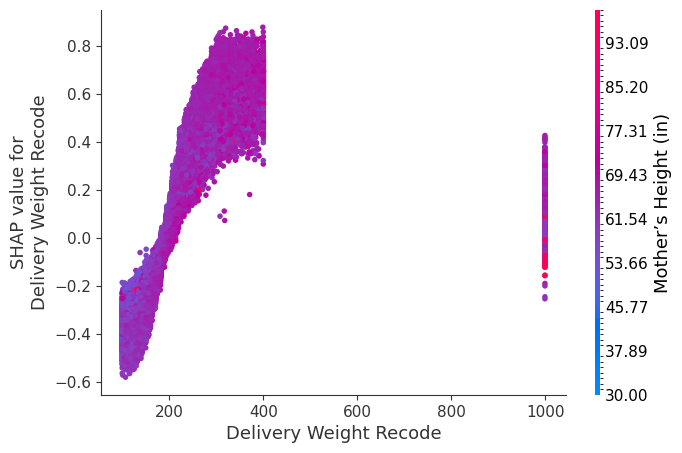


📈 SHAP Dependence Plot for: Birth Weight (grams)


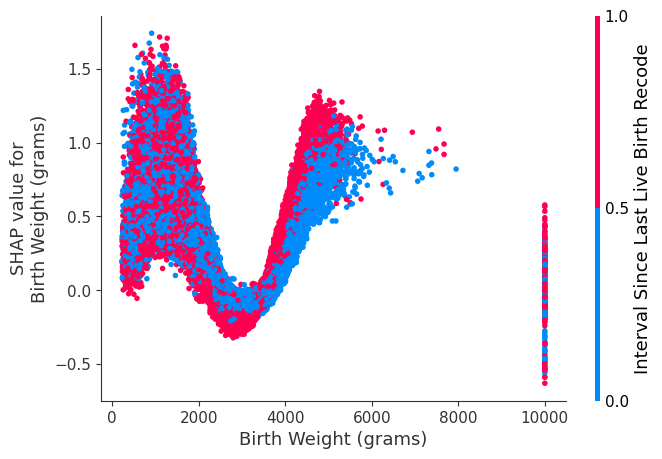


📈 SHAP Dependence Plot for: Combined Gestational Age (weeks)


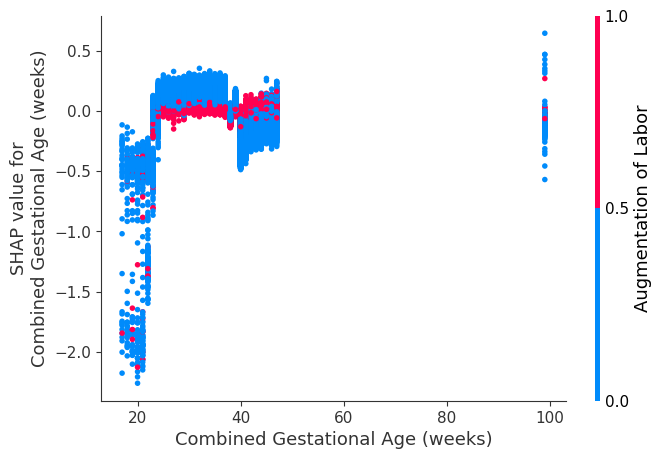


📈 SHAP Dependence Plot for: Body Mass Index Recode


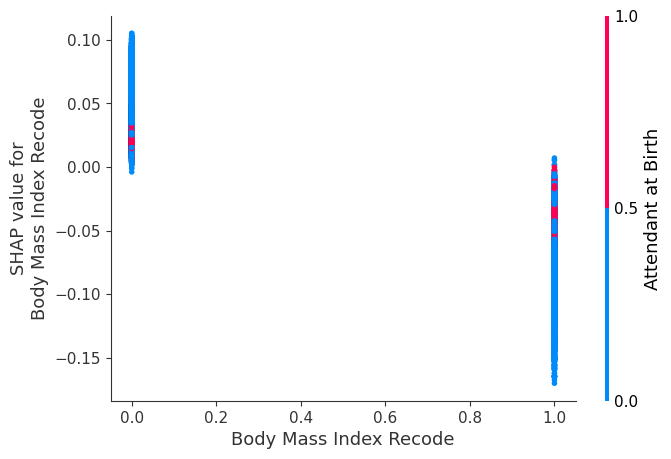


📈 SHAP Dependence Plot for: Weight Gain


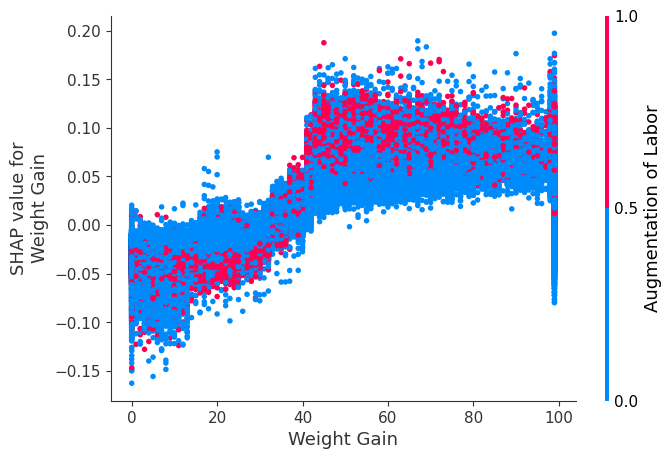

In [ ]:
import numpy as np
import pandas as pd

selected_features = [
    "Mother’s Age",
    "Mother’s Height (in)",
    "Delivery Weight Recode",
    "Birth Weight (grams)",
    "Combined Gestational Age (weeks)",
    "Body Mass Index Recode",
    "Weight Gain"
]
for feature in selected_features:
    if feature in X_test_renamed.columns:
        print(f"\n📈 SHAP Dependence Plot for: {feature}")
        shap.dependence_plot(
            ind=feature,
            shap_values=shap_values,
            features=X_test_renamed
        )
    else:
        print(f"⚠️ Feature '{feature}' not found in test set columns.")



In [ ]:
############# Previous Code #####################

# Convert target to binary: 1 for C-section, 0 for Vaginal
y_train_bin = (y_train == 'C-section').astype(int)
y_valid_bin = (y_valid == 'C-section').astype(int)
y_test_bin  = (y_test == 'C-section').astype(int)

# Function to clean column names for XGBoost
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace('[', '_').replace(']', '_').replace('<', '_')
        # Add more replacements if needed based on the error message
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Clean column names before creating DMatrix
X_train_cleaned_cols = clean_col_names(X_train.copy())
X_valid_cleaned_cols = clean_col_names(X_valid.copy())
X_test_cleaned_cols  = clean_col_names(X_test.copy())


# Convert to DMatrix
dtrain = xgb.DMatrix(data=X_train_cleaned_cols, label=y_train_bin)
dvalid = xgb.DMatrix(data=X_valid_cleaned_cols, label=y_valid_bin)
dtest  = xgb.DMatrix(data=X_test_cleaned_cols,  label=y_test_bin)

In [ ]:
### 3. Gradient Boosting Model ####

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the model
gb_model = GradientBoostingClassifier(
    n_estimators=100,      # number of boosting stages
    learning_rate=0.1,     # shrinkage rate
    max_depth=3,           # limit depth of each tree
    random_state=1
)

# Train the model
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=1)


🔍 Gradient Boosting - C-section Risk Prediction
Accuracy: 0.7782579394787058
Confusion Matrix:
 [[420285  36758]
 [111636 100540]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85    457043
           1       0.73      0.47      0.58    212176

    accuracy                           0.78    669219
   macro avg       0.76      0.70      0.71    669219
weighted avg       0.77      0.78      0.76    669219

AUC: 0.8371397207826881


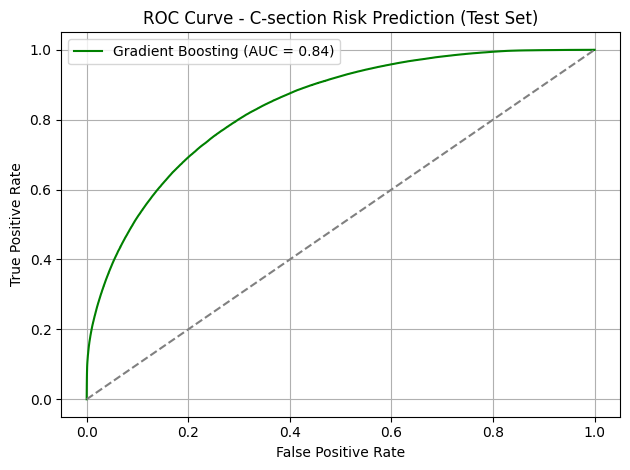

In [ ]:
# Get probability of C-section
gb_csection_index = list(gb_model.classes_).index('C-section')
y_test_prob_gb = gb_model.predict_proba(X_test)[:, gb_csection_index]
y_test_pred_gb = gb_model.predict(X_test)

print("\n🔍 Gradient Boosting - C-section Risk Prediction")
print("Accuracy:", accuracy_score(y_test_bin, y_test_pred_gb == 'C-section'))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred_gb == 'C-section'))
print("Classification Report:\n", classification_report(y_test_bin, y_test_pred_gb == 'C-section'))
print("AUC:", roc_auc_score(y_test_bin, y_test_prob_gb))

# ROC Curve
fpr_gb, tpr_gb, _ = roc_curve(y_test_bin, y_test_prob_gb)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {roc_auc_score(y_test_bin, y_test_prob_gb):.2f})", color='green')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - C-section Risk Prediction (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
### OPTUNA ###

!pip install optuna
import optuna
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 24.2 MB/s eta 0:00:00


In [ ]:
### 1. Optuna for Random Forest ###

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': SEED,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_valid)
    return f1_score(y_valid == 'C-section', preds == 'C-section')

study_rf = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_rf.optimize(objective_rf, n_trials=30)

best_rf = RandomForestClassifier(**study_rf.best_params, random_state=SEED)
best_rf.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))


[I 2025-06-19 20:41:48,259] A new study created in memory with name: no-name-b287036d-5bc1-4312-9db1-49262d80b44e
[I 2025-06-19 20:45:15,237] Trial 0 finished with value: 0.5369489491695593 and parameters: {'n_estimators': 267, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5369489491695593.
[I 2025-06-19 20:45:53,365] Trial 1 finished with value: 0.1865468560356025 and parameters: {'n_estimators': 158, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5369489491695593.
[I 2025-06-19 20:48:50,354] Trial 2 finished with value: 0.49023058291829275 and parameters: {'n_estimators': 259, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5369489491695593.
[I 2025-06-19 20:51:33,893] Trial 3 finished with value: 0.5665400914513273 and parameters: {'n_estimators': 181, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 3 with value

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=331, random_state=1)

In [ ]:
import hashlib
import random
import optuna
import xgboost as xgb
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# 🔐 Step 1: Generate 5 deterministic seeds from your student ID
def generate_seeded_random_numbers(student_id, n=5):
    md5 = hashlib.md5(student_id.encode('utf-8')).hexdigest()
    seed_number = int(md5, 16)
    random.seed(seed_number)
    return [random.randint(0, 2**31 - 1) for _ in range(n)]

# 🆔 Set your student ID here
student_id = "311982"
seeds = generate_seeded_random_numbers(student_id)
print(f"✅ Seeds from student ID {student_id}:\n{seeds}")

# Function to clean column names for XGBoost
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace('[', '_').replace(']', '_').replace('<', '_')
        # Add more replacements if needed based on the error message
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Clean column names before creating DMatrix
X_train_cleaned_cols = clean_col_names(X_train.copy())
X_valid_cleaned_cols = clean_col_names(X_valid.copy())


# 🔁 Collect results
best_models = []
best_scores = []
best_studies = []

# 🔁 Step 2: Loop over 5 seeds for Optuna tuning
for i, seed in enumerate(seeds):
    print(f"\n🔍 Optuna Tuning for Seed {seed} (#{i+1}/5)")

    def objective_xgb(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'eta': trial.suggest_float('eta', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'seed': seed,
            'verbosity': 0
        }

        y_train_bin = (y_train == 'C-section').astype(int)
        y_valid_bin = (y_valid == 'C-section').astype(int)
        dtrain = xgb.DMatrix(X_train_cleaned_cols, label=y_train_bin)
        dvalid = xgb.DMatrix(X_valid_cleaned_cols, label=y_valid_bin)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=100,
            evals=[(dvalid, 'valid')],
            early_stopping_rounds=10,
            verbose_eval=False
        )

        preds = model.predict(dvalid)
        return f1_score(y_valid_bin, preds > 0.5)

    # Run Optuna
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
    study.optimize(objective_xgb, n_trials=30, show_progress_bar=False)


[I 2025-06-26 16:07:51,031] A new study created in memory with name: no-name-85b7293b-6473-4591-8f18-988f0fee561c


✅ Seeds from student ID 311982:
[318229462, 2068703232, 59169051, 1141743330, 1435688210]

🔍 Optuna Tuning for Seed 318229462 (#1/5)


[I 2025-06-26 16:08:26,200] Trial 0 finished with value: 0.5527399448579441 and parameters: {'max_depth': 4, 'eta': 0.04737340592094348, 'subsample': 0.7393427289623173, 'colsample_bytree': 0.8394797585430962}. Best is trial 0 with value: 0.5527399448579441.
[I 2025-06-26 16:09:13,775] Trial 1 finished with value: 0.5265348531048537 and parameters: {'max_depth': 6, 'eta': 0.022087634499987387, 'subsample': 0.8857231119136193, 'colsample_bytree': 0.7183766766820697}. Best is trial 0 with value: 0.5527399448579441.
[I 2025-06-26 16:10:03,591] Trial 2 finished with value: 0.6012234294204065 and parameters: {'max_depth': 7, 'eta': 0.04533244916540782, 'subsample': 0.633646289509723, 'colsample_bytree': 0.9532969941346936}. Best is trial 2 with value: 0.6012234294204065.
[I 2025-06-26 16:10:57,369] Trial 3 finished with value: 0.6331143963319309 and parameters: {'max_depth': 8, 'eta': 0.22460418338938362, 'subsample': 0.6037593283602941, 'colsample_bytree': 0.6416880438217681}. Best is tria


🔍 Optuna Tuning for Seed 2068703232 (#2/5)


[I 2025-06-26 16:35:29,342] Trial 0 finished with value: 0.632201468890601 and parameters: {'max_depth': 6, 'eta': 0.2976275916922921, 'subsample': 0.9092991634176422, 'colsample_bytree': 0.7623405906610254}. Best is trial 0 with value: 0.632201468890601.
[I 2025-06-26 16:36:12,781] Trial 1 finished with value: 0.6304885288724126 and parameters: {'max_depth': 6, 'eta': 0.21524832888431067, 'subsample': 0.7936458005471481, 'colsample_bytree': 0.6896551731399362}. Best is trial 0 with value: 0.632201468890601.
[I 2025-06-26 16:36:56,786] Trial 2 finished with value: 0.6340806729454695 and parameters: {'max_depth': 9, 'eta': 0.29012258336263413, 'subsample': 0.8538906515928325, 'colsample_bytree': 0.6882877611792027}. Best is trial 2 with value: 0.6340806729454695.
[I 2025-06-26 16:37:33,344] Trial 3 finished with value: 0.6336210955893894 and parameters: {'max_depth': 10, 'eta': 0.2796750995013006, 'subsample': 0.7208222617870489, 'colsample_bytree': 0.7993071667872156}. Best is trial 2 


🔍 Optuna Tuning for Seed 59169051 (#3/5)


[I 2025-06-26 17:01:00,952] Trial 0 finished with value: 0.6207230003062195 and parameters: {'max_depth': 5, 'eta': 0.16278646106770384, 'subsample': 0.9822799395760109, 'colsample_bytree': 0.8513956944360477}. Best is trial 0 with value: 0.6207230003062195.
[I 2025-06-26 17:02:02,722] Trial 1 finished with value: 0.631618293523983 and parameters: {'max_depth': 10, 'eta': 0.0867593009970213, 'subsample': 0.7511676719719191, 'colsample_bytree': 0.9785075042286836}. Best is trial 1 with value: 0.631618293523983.
[I 2025-06-26 17:02:51,928] Trial 2 finished with value: 0.6334750591397427 and parameters: {'max_depth': 10, 'eta': 0.24851069032216422, 'subsample': 0.9274962434647227, 'colsample_bytree': 0.7666607599574359}. Best is trial 2 with value: 0.6334750591397427.
[I 2025-06-26 17:03:34,825] Trial 3 finished with value: 0.6314924720763798 and parameters: {'max_depth': 6, 'eta': 0.2595061667293238, 'subsample': 0.8393056153886594, 'colsample_bytree': 0.7954668998450283}. Best is trial 


🔍 Optuna Tuning for Seed 1141743330 (#4/5)


[I 2025-06-26 17:27:19,970] Trial 0 finished with value: 0.6105166615713848 and parameters: {'max_depth': 5, 'eta': 0.09454733941725998, 'subsample': 0.7543443147140241, 'colsample_bytree': 0.8525761813301722}. Best is trial 0 with value: 0.6105166615713848.
[I 2025-06-26 17:28:24,375] Trial 1 finished with value: 0.6046605618363211 and parameters: {'max_depth': 10, 'eta': 0.030162331604525375, 'subsample': 0.6686035146913738, 'colsample_bytree': 0.7483235835386823}. Best is trial 0 with value: 0.6105166615713848.
[I 2025-06-26 17:28:54,032] Trial 2 finished with value: 0.6091216216216216 and parameters: {'max_depth': 3, 'eta': 0.25121913266632706, 'subsample': 0.6614706064060312, 'colsample_bytree': 0.8897002942560592}. Best is trial 0 with value: 0.6105166615713848.
[I 2025-06-26 17:29:23,679] Trial 3 finished with value: 0.6111139748073109 and parameters: {'max_depth': 3, 'eta': 0.26939031339896086, 'subsample': 0.8567550811489946, 'colsample_bytree': 0.7016395355666349}. Best is tr


🔍 Optuna Tuning for Seed 1435688210 (#5/5)


[I 2025-06-26 17:52:54,419] Trial 0 finished with value: 0.6288887653624926 and parameters: {'max_depth': 7, 'eta': 0.14069428167393475, 'subsample': 0.9377518962902502, 'colsample_bytree': 0.7047627857725385}. Best is trial 0 with value: 0.6288887653624926.
[I 2025-06-26 17:53:27,900] Trial 1 finished with value: 0.6227999104506252 and parameters: {'max_depth': 4, 'eta': 0.2661244619596305, 'subsample': 0.8907587128789252, 'colsample_bytree': 0.9755551599099728}. Best is trial 0 with value: 0.6288887653624926.
[I 2025-06-26 17:54:15,280] Trial 2 finished with value: 0.6322395345656542 and parameters: {'max_depth': 7, 'eta': 0.19760470023493548, 'subsample': 0.8875940984003974, 'colsample_bytree': 0.8780588280887439}. Best is trial 2 with value: 0.6322395345656542.
[I 2025-06-26 17:55:04,337] Trial 3 finished with value: 0.6347668838607488 and parameters: {'max_depth': 8, 'eta': 0.29411908137370063, 'subsample': 0.7855633706665132, 'colsample_bytree': 0.9137024525805217}. Best is trial

In [ ]:
# Average F1 across 5 seeds
avg_f1 = sum(best_scores) / len(best_scores)
print(f"\n📊 Average Validation F1 Score: {avg_f1:.4f}")

# Select model closest to average
best_index = min(range(len(best_scores)), key=lambda i: abs(best_scores[i] - avg_f1))
final_xgb_model = best_models[best_index]
final_xgb_study = best_studies[best_index]

print(f"✅ Selected Seed: {seeds[best_index]}")
print(f"F1 Closest to Average: {best_scores[best_index]:.4f}")
print("Best Hyperparameters:", final_xgb_study.best_params)



📊 Average Validation F1 Score: 0.6354
✅ Selected Seed: 59169051
F1 Closest to Average: 0.6355
Best Hyperparameters: {'max_depth': 10, 'eta': 0.19059607827794325, 'subsample': 0.7450497112512064, 'colsample_bytree': 0.8639935865070842}


In [ ]:
# Clean column names: remove brackets, angle brackets, and enforce string type
X_train.columns = X_train.columns.astype(str).str.replace(r"[\[\]<>]", "_", regex=True)
X_valid.columns = X_valid.columns.astype(str).str.replace(r"[\[\]<>]", "_", regex=True)
X_test.columns  = X_test.columns.astype(str).str.replace(r"[\[\]<>]", "_", regex=True)

# Test set binary labels
y_test_bin = (y_test == 'C-section').astype(int)
dtest = xgb.DMatrix(X_test)

# Predict
y_test_pred_prob = final_xgb_model.predict(dtest)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Report
print("\n🧪 Test Set Performance (C-section = Positive Class)")
print("Accuracy:", accuracy_score(y_test_bin, y_test_pred))
print("F1 Score:", f1_score(y_test_bin, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test_bin, y_test_pred_prob))



🧪 Test Set Performance (C-section = Positive Class)
Accuracy: 0.7913567905274655
F1 Score: 0.6311056157926996
ROC-AUC: 0.8512834586704695


In [ ]:
y_test_bin = (y_test == 'C-section').astype(int)
dtest = xgb.DMatrix(X_test)  # after cleaning column names!
y_test_pred_prob = final_xgb_model.predict(dtest)



🔍 XGBoost - C-section Risk Prediction
Accuracy: 0.7913567905274655
Confusion Matrix:
 [[410153  46890]
 [ 92738 119438]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.85    457043
           1       0.72      0.56      0.63    212176

    accuracy                           0.79    669219
   macro avg       0.77      0.73      0.74    669219
weighted avg       0.78      0.79      0.78    669219

AUC: 0.8512834586704695


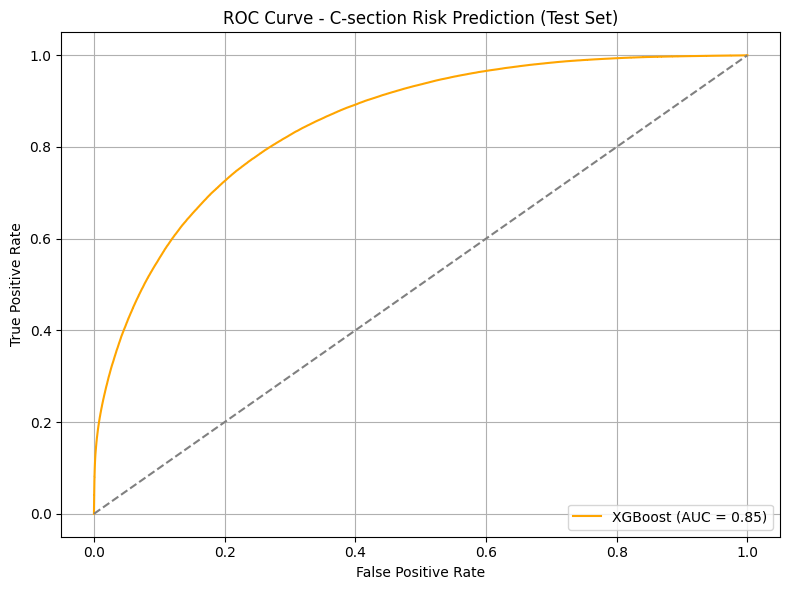

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Binary target: C-section = 1, Vaginal = 0
y_test_bin = (y_test == 'C-section').astype(int)

# Predict probabilities and class labels
y_test_prob_xgb = final_xgb_model.predict(xgb.DMatrix(X_test))
y_test_pred_xgb = (y_test_prob_xgb > 0.5).astype(int)

# 🔍 Evaluation
print("\n🔍 XGBoost - C-section Risk Prediction")
print("Accuracy:", accuracy_score(y_test_bin, y_test_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_test_pred_xgb))
print("Classification Report:\n", classification_report(y_test_bin, y_test_pred_xgb))
print("AUC:", roc_auc_score(y_test_bin, y_test_prob_xgb))

# 📊 ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bin, y_test_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test_bin, y_test_prob_xgb):.2f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - C-section Risk Prediction (Test Set)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Save Model -Final XGB
joblib.dump(final_xgb_model, '/content/drive/My Drive/datasets/final_xgb_model.pkl')


joblib.dump(final_xgb_study, '/content/drive/My Drive/datasets/final_xgb_study.pkl')


['/content/drive/My Drive/datasets/final_xgb_study.pkl']

In [ ]:
# Reload next time
import joblib

final_xgb_study = joblib.load('/content/drive/My Drive/datasets/final_xgb_study.pkl')

